
# Sintonia de PID por Ziegler–Nichols (First Method)

Sumário:

1. **Ziegler–Nichols: Método Curva de Reação**  
    - Sintonia do PID usando o método de Ziegler–Nichols (método da curva de reação).  
2. **FOPDT: Sistema de primeira ordem com atraso**  
    - Modelo *First Order Plus Dead Time*.  
3. **Curva de Reação: Resposta ao degrau**  
    - Aproximação para o modelo FOPDT.  
4. **Simulação em malha fechada com PID**  
    - Implementação do PID para a simulação.

---


In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lti, cont2discrete


<a name="1"></a>
## 1. Ziegler–Nichols: Método Curva de Reação

O método da curva de reação de Ziegler–Nichols, também conhecido como primeiro método de ZN, é aplicado em processos cuja resposta ao degrau pode ser bem aproximada por um modelo do tipo FOPDT (First Order Plus Dead Time), ou seja, um sistema de primeira ordem com atraso de transporte. Esse método é especialmente indicado quando o processo apresenta comportamento relativamente simples, com dinâmica dominante de primeira ordem e um tempo morto claramente observável. Em processos altamente não lineares, com múltiplas constantes de tempo ou comportamento oscilatório natural, o método deixa de ser adequado.

O procedimento prático consiste em aplicar ao processo uma entrada em degrau e registrar a resposta no tempo. A curva obtida é então ajustada ao modelo FOPDT, permitindo extrair os parâmetros fundamentais: o ganho estático do processo (K), a constante de tempo (T) e o tempo morto (L). Com esses valores, aplicam-se as fórmulas empíricas propostas por Ziegler e Nichols para calcular os ganhos do controlador proporcional, integral e derivativo (Kp, Ki e Kd) conforme a indicado a seguir.

 **PID parameters**:
- $ K_p = 1.2 \cdot \frac{T}{K L} $
- $ K_i = 0.6 \cdot \frac{T}{K L^2} $
- $ K_d = 0.5 \cdot \frac{T}{K} $

O método da curva de reação é bastante útil por sua simplicidade e pelo fato de exigir apenas um ensaio em malha aberta. Entretanto, uma limitação importante é que os parâmetros obtidos tendem a resultar em um controlador com comportamento agressivo, produzindo overshoot elevado e, em alguns casos, instabilidade. Por isso, muitas vezes os ganhos obtidos são usados como ponto de partida, sendo posteriormente ajustados de forma mais conservadora reduzindo-se os ganhos.



In [2]:

def ziegler_nichols_first_method(K, L, T):
    """Return PID parameters using Ziegler-Nichols first method."""
    return {
        "Kp": 1.2 * T / (K * L),
        "Ki": 0.6 * T / (K * L**2), # = Kp*Ti = Kp/Tn = Kp/(2L)
        "Kd": 0.5 * T / K           # = Kp*Td = Kp*Tv = Kp*(L/2)
    }


<a name="2"></a>
## 2. FOPDT: Sistema de primeira ordem com atraso

O modelo FOPDT (*First Order Plus Dead Time*) é definido como:

$
G(s) = \frac{K \cdot e^{-Ls}}{T s + 1}
$

Onde:
- **K** = Ganho do processo  
- **L** = Atraso (dead time)  
- **T** = Constante de Tempo


In [3]:

def simulate_process_FOPDT(u, dt, K, T, L):
    """Simulate FOPDT process with Zero-Order Hold discretization."""
    num = [K]
    den = [T, 1]
    sysd = cont2discrete((num, den), dt, method="zoh")
    b, a = sysd[0].flatten(), sysd[1].flatten()

    # Apply time delay
    delay_steps = int(L / dt)
    u_delayed = np.concatenate((np.zeros(delay_steps), u[:-delay_steps]))

    y = np.zeros_like(u)
    for k in range(2, len(u)):
        y[k] = -a[1]*y[k-1] + b[0]*u_delayed[k-1] + b[1]*u_delayed[k-2]
    return y

def simulate_process_FOPDT_euler(u, dt, K, T, L):
    """Simulate FOPDT process using Euler approximation."""
    n = len(u)
    y = np.zeros(n)
    delay_steps = int(L / dt)

    for k in range(1, n):
        u_delayed = u[k - delay_steps] if k - delay_steps >= 0 else 0.0
        y[k] = y[k-1] + dt/T * (-y[k-1] + K*u_delayed)
    return y


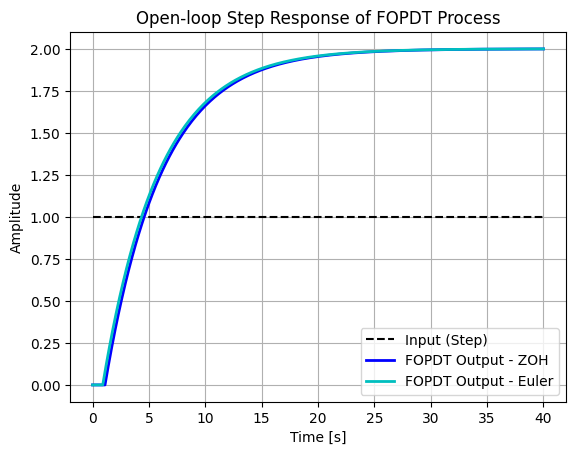

In [4]:
# Example:

# Process parameters
K_process = 2.0
L = 1.0
T = 5.0

# Simulation configuration
dt = 0.1
sim_time = 40.0
n_steps = int(sim_time / dt)
t = np.linspace(0, sim_time, n_steps)

# Step input
u_open = np.ones(n_steps)

# Simulate using both methods
y_open_1 = simulate_process_FOPDT(u_open, dt, K_process, T, L)
y_open_2 = simulate_process_FOPDT_euler(u_open, dt, K_process, T, L)

# Plot
plt.plot(t, u_open, 'k--', label="Input (Step)")
plt.plot(t, y_open_1, 'b-', linewidth=2, label="FOPDT Output - ZOH")
plt.plot(t, y_open_2, 'c-', linewidth=2, label="FOPDT Output - Euler")
plt.title("Open-loop Step Response of FOPDT Process")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


<a name="3"></a>
## 3. Curva de Reação: Resposta ao degrau

Para se fazer a aproximação do modelo real para o medelo FOPDT deve obter a curva de resposta ao degrau do sistema e obter (manualmente) os seguintes parâmetros:
- **K** = Ganho do processo  
- **L** = Atraso (dead time)  
- **T** = Constante de Tempo

Para isto deve se traçar uma reta tangente ao ponto de inflexão (meio da curva) durante o transitório da resposta ao degrau, e também uma assíntota horizontal no valor da saída. Com essas duas retas e o valor do degrau aplicado pode-se obter os parâmetros necessários.

**Aproximação para FOPDT**

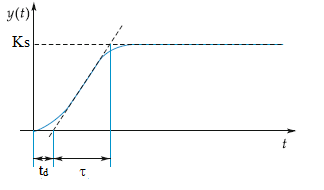


- **K** = $ \frac{\Delta Y}{\Delta U} = \frac{Saída}{Degrau}$ 
- **L** = $ td  $
- **T** = $ \tau $

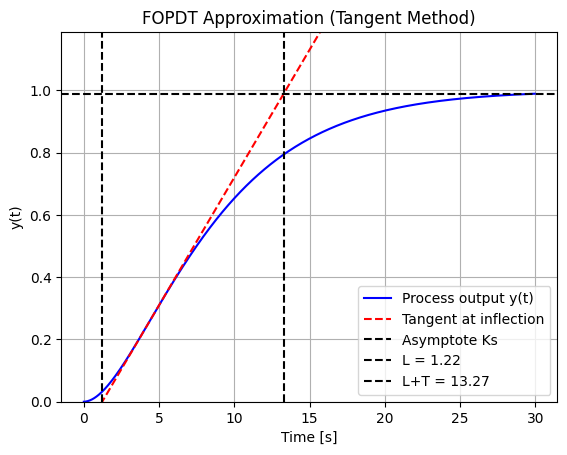

{'K': np.float64(0.9893904491431507), 'L': np.float64(1.220127848345947), 'T': [np.float64(12.054809264821785), np.float64(8.279872151654054)]}


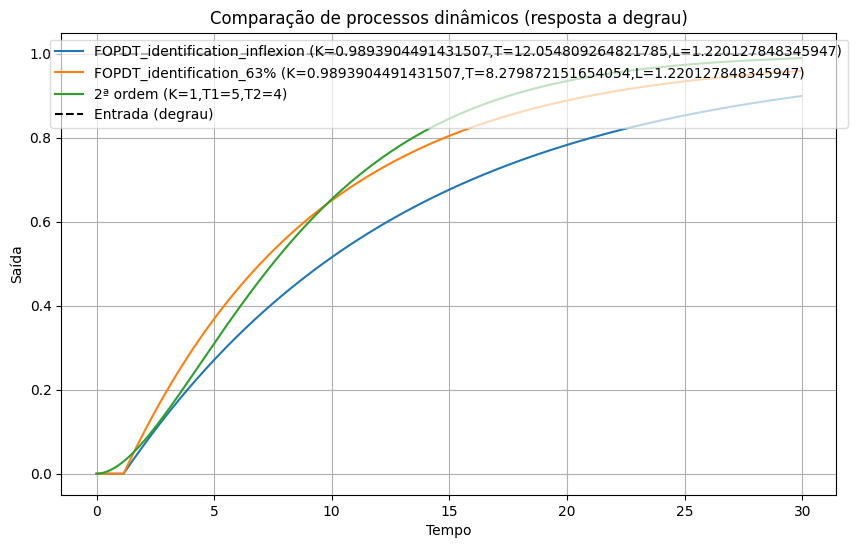

In [ ]:
from examples.PID_simulate import demo_fopdt_identification_second_order

#demo_fopdt_identification_second_order()

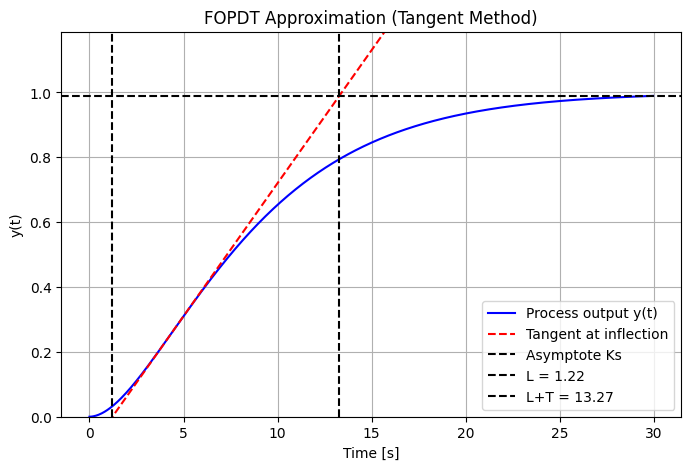

{'K': np.float64(0.9893904491431507), 'L': np.float64(1.220127848345947), 'T': [np.float64(12.054809264821785), np.float64(8.279872151654054)]}


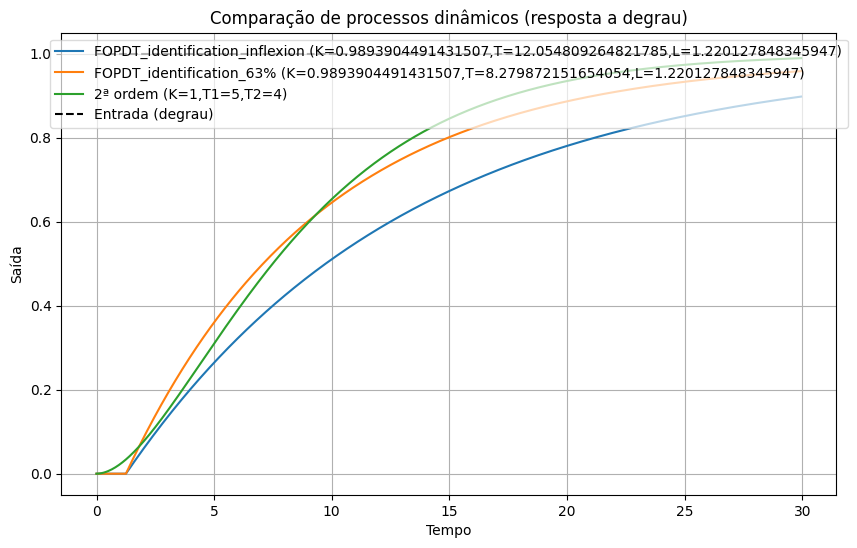

In [12]:
def simulate_process_second_order(u, dt, K, T1, T2):
    """
    Second-order system: G(s) = K / ((T1*s+1)(T2*s+1))
    """
    n = len(u)
    y = np.zeros(n)
    dy = np.zeros(n)  # derivada aproximada

    for k in range(1, n):
        dy[k] = dy[k-1] + dt*((- (T1+T2)*dy[k-1] - y[k-1] + K*u[k])/(T1*T2))
        y[k] = y[k-1] + dt*dy[k]
    return y

def fopdt_identification(process_func, params, dt=0.05, sim_time=30, step=1.0):
    """
    Approximate a process as FOPDT using the tangent method.
    
    Parameters:
    - process_func : function that simulates the process
    - params       : dict with process parameters
    - dt           : simulation time step
    - sim_time     : total simulation time
    - step         : input step magnitude
    """
    n = int(sim_time/dt)
    t = np.arange(n)*dt
    u = np.ones(n) * step
    y = process_func(u, dt, **params)

    # Process gain (steady state change / input change)
    K = (y[-1] - y[0]) / step

    # Numerical derivative
    dy = np.gradient(y, dt)

    # Inflexion point (max derivative)
    k_infl = np.argmax(dy)
    t_infl, y_infl, slope = t[k_infl], y[k_infl], dy[k_infl]

    # Tangent line
    tangent = y_infl + slope*(t - t_infl)

    # Dead time L: when tangent crosses y=0
    L = t_infl - y_infl/slope

    # Tau T: time between L and tangent crossing steady state
    T=[0,0]
    
        #Option 1: Inflexion
    T[0] = ( (K*step - y_infl)/slope + t_infl ) - L
    
        #Option 2: 63.2% of Y
    y_target = K * step * (1 - np.exp(-1))  # 63.2% of Y
    idx_tau = np.where(y >= y_target)[0][0]  # y >= alvo
    T[1] = t[idx_tau] - L


    # === Plot ===
    plt.figure(figsize=(8,5))
    plt.plot(t, y, 'b', label="Process output y(t)")
    plt.plot(t, tangent, 'r--', label="Tangent at inflection")
    plt.axhline(K*step, color="k", linestyle="--", label="Asymptote Ks")
    plt.axvline(L, color="k", linestyle="--", label=f"L = {L:.2f}")
    plt.axvline(L+T[0], color="k", linestyle="--", label=f"L+T = {L+T[0]:.2f}")
    
    plt.title("FOPDT Approximation (Tangent Method)")
    plt.xlabel("Time [s]")
    plt.ylabel("y(t)")
    plt.ylim(bottom=min(y),top=max(y)*1.2)
    plt.legend()
    plt.grid(True)
    plt.show()

    return {"K": K, "L": L, "T": T}

def demo_fopdt_identification_second_order():
    # Aproximar o processo de 2ª ordem como FOPDT
    second_order_params = {"K":1, "T1":5, "T2":4}
    fopdt_params = fopdt_identification(simulate_process_second_order, second_order_params)
    print(fopdt_params)
    
    """Comparar processos"""
    dt, sim_time = 0.05, 30
    n = int(sim_time/dt)
    u = np.ones(n)  # entrada degrau unitário

    cases = {
        f"FOPDT_identification_inflexion (K={fopdt_params["K"]},T={fopdt_params["T"][0]},L={fopdt_params["L"]})": (simulate_process_FOPDT, {"K":fopdt_params["K"], "L":fopdt_params["L"],"T":fopdt_params["T"][0]}),
        f"FOPDT_identification_63% (K={fopdt_params["K"]},T={fopdt_params["T"][1]},L={fopdt_params["L"]})": (simulate_process_FOPDT, {"K":fopdt_params["K"], "L":fopdt_params["L"],"T":fopdt_params["T"][1]}),
        f"2ª ordem (K={second_order_params["K"]},T1={second_order_params["T1"]},T2={second_order_params["T2"]})": (simulate_process_second_order, second_order_params),
    }

    plt.figure(figsize=(10,6))
    for label,(func,params) in cases.items():
        y = func(u, dt, **params)
        plt.plot(np.arange(n)*dt, y, label=label)

    plt.plot(np.arange(n)*dt, u, 'k--', label="Entrada (degrau)")
    plt.title("Comparação de processos dinâmicos (resposta a degrau)")
    plt.xlabel("Tempo")
    plt.ylabel("Saída")
    plt.legend(loc="upper center", framealpha=0.7)
    plt.grid()
    plt.show()
    
demo_fopdt_identification_second_order()

<a name="4"></a>
## 4. Simulação em malha fechada com PID

Implementação de um  **Controlador PID** básico.


In [15]:

# def simulate_pid_FOPDT(Kp, Ki, Kd, K, T, L, dt, sim_time, SP=1.0):
#     """Simulate a closed-loop system with PID controller."""
#     n_steps = int(sim_time / dt)
#     t = np.linspace(0, sim_time, n_steps)
# 
#     u = np.zeros(n_steps)
#     y = np.zeros(n_steps)
#     e = np.zeros(n_steps)
#     sp = np.ones(n_steps) * SP
# 
#     I = 0.0
#     prev_e = 0.0
# 
#     for k in range(1, n_steps):
#         e[k] = sp[k] - y[k-1]
#         P = Kp * e[k]
#         I += Ki * e[k] * dt
#         D = Kd * (e[k] - prev_e) / dt
#         prev_e = e[k]
#         u[k] = P + I + D
#         y[k] = simulate_process_FOPDT_euler(u[:k+1], dt, K, T, L)[k]
#     return t, sp, y, u

def simulate_pid(Kp, Ki, Kd, process_func, process_params, dt, sim_time, 
                 SP=1.0, saturation=[float('-inf'), float('inf')], 
                 D_on="y", D_filter=float('inf'), anti_windup=0):
    """
    Generic PID simulator with any process model.
    
    process_func: function that simulates the process (e.g., simulate_process_FOPDT)
    process_params: dict with parameters required by process_func
                    (ex: {"K":1, "T":5, "L":2} for FOPDT)
    """   
    n_steps = int(sim_time/dt)
    t = np.linspace(0, sim_time, n_steps)

    u = np.zeros(n_steps)
    y = np.zeros(n_steps)
    e = np.zeros(n_steps)
    sp = np.ones(n_steps) * SP

    I = 0.0
    D = 0.0
    prev_y = 0.0
    
    # D_filter
    Td = Kd/Kp if Kp != 0 else 0.0
    alpha = Td / (Td + D_filter*dt) if Td > 0 else 0.0  # D_filter: inf => no filtering ; 0 => strong filtering
    #print(f"alpha (D_filter): {alpha}")
    
    for k in range(1, n_steps):
        e[k] = sp[k] - y[k-1]
        P = Kp * e[k]
        I += Ki * e[k] * dt
        
        #D = Kd * (e[k] - e[k-1]) / dt      # D basic
        #D = Kd * (e[k] - e[k-1]) / dt if (D_on=="e") else  -Kd * (y[k-1] - prev_y) / dt     # D on "error" or "y"
        D = alpha*D + (1-alpha)*Kd * (e[k] - e[k-1]) / dt if (D_on=="e") else  alpha*D + (1-alpha)*(-Kd) * (y[k-1] - prev_y) / dt     # D on "error" or "y", with D_filter
        prev_y = y[k-1]
        
        #u[k] = P + I + D
        u_unsat = P + I + D
        u[k] = min( max( u_unsat , saturation[0]), saturation[1]) #saturation
        
        # Anti-windup (back-calculation correction on integrator)
        I += anti_windup * (u[k] - u_unsat)
        
        # Simulate process
        y[:k+1] = process_func(u[:k+1], dt=dt, **process_params)
        
    return t, sp, y, u

def plot_pid_response(t, sp, y, u):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    ax[0].plot(t, sp, 'r--', label="Setpoint (SP)")
    ax[0].plot(t, y, 'b-', label="Process Variable (PV)")
    ax[0].set_ylabel("Output")
    ax[0].set_title("Step Response - PID Control")
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(t, u, 'g-', label="Control Signal (MV)")
    ax[1].set_xlabel("Time [s]")
    ax[1].set_ylabel("Control Action")
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout()
    plt.show()


<a name="5"></a>
## Simulação

Feita a aproximação do modelo real para o modelo FOPDT, os parâmetros encontrados são passados para as funções de sintonia de Zigler-Nichols que retorna os parâmetros do PID. Com os parâmetros obtidos para o PID é possível simular a resposta do sistema e, com isso, avaliar e fazer ajustes finos. 

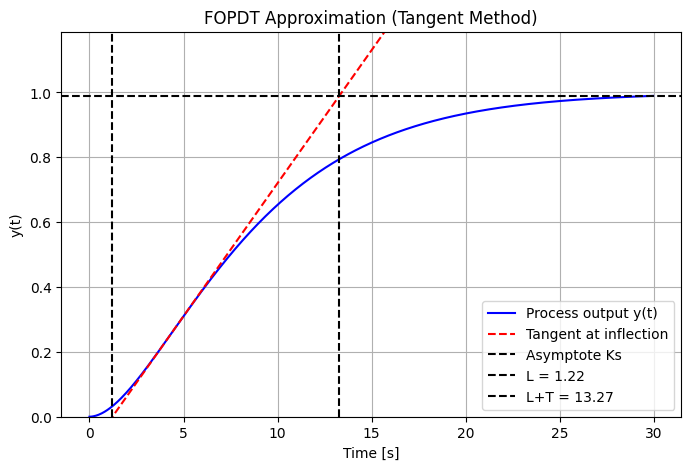

{'K': np.float64(0.9893904491431507), 'L': np.float64(1.220127848345947), 'T': [np.float64(12.054809264821785), np.float64(8.279872151654054)]}
Ziegler-Nichols PID Parameters: {'Kp': np.float64(11.983082131236623), 'Ki': np.float64(4.910584635651649), 'Kd': np.float64(6.0920384238910446)}


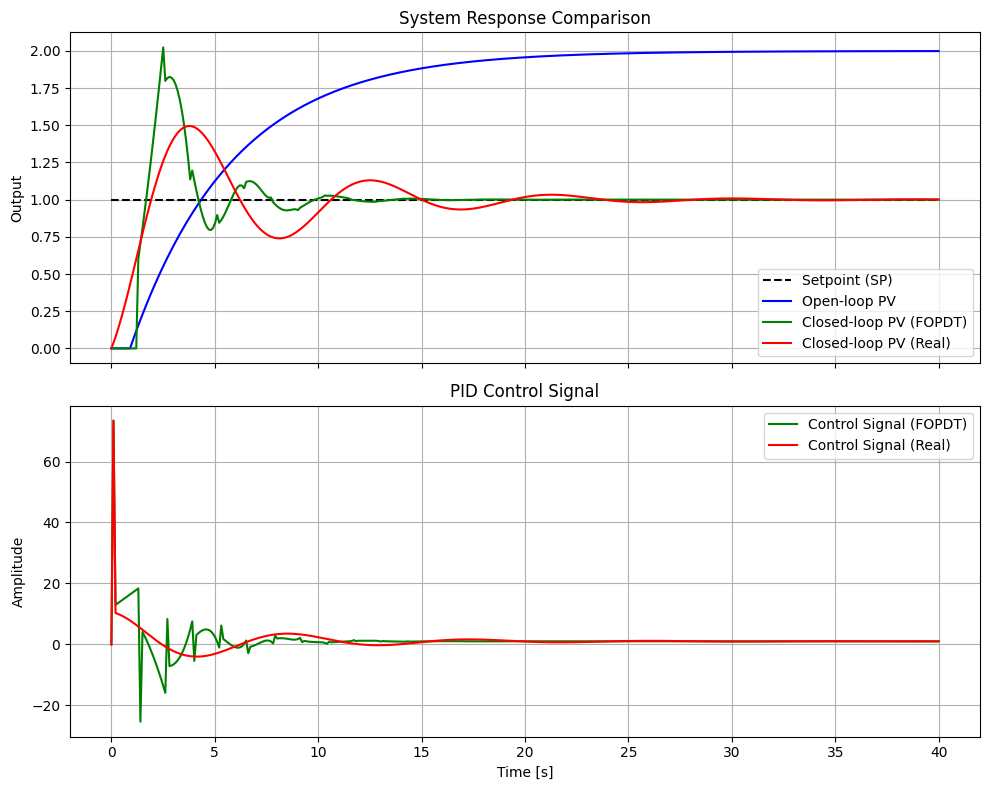

In [14]:
# Aproximar o processo de 2ª ordem como FOPDT
second_order_params = {"K":1, "T1":5, "T2":4}
fopdt_params = fopdt_identification(simulate_process_second_order, second_order_params)
print(fopdt_params)

# Get tuned PID parameters
pid_params = ziegler_nichols_first_method(fopdt_params["K"], fopdt_params["L"], fopdt_params["T"][0])
print("Ziegler-Nichols PID Parameters:", pid_params)

# Closed-loop simulation
t, sp, y_pid_fopdt, u_pid_fopdt = simulate_pid(
    pid_params["Kp"], pid_params["Ki"], pid_params["Kd"],
    simulate_process_FOPDT_euler, {"K":fopdt_params["K"], "L":fopdt_params["L"], "T":fopdt_params["T"][0]}, dt, sim_time, D_on="e"
)
t, sp, y_pid, u_pid = simulate_pid(
    pid_params["Kp"], pid_params["Ki"], pid_params["Kd"], 
    simulate_process_second_order, second_order_params, dt, sim_time, D_on="e"
)

# Plot comparison
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# System response
axs[0].plot(t, sp, "k--", label="Setpoint (SP)")
axs[0].plot(t, y_open_2, label="Open-loop PV", color="b")
axs[0].plot(t, y_pid_fopdt, label="Closed-loop PV (FOPDT)", color="g")
axs[0].plot(t, y_pid, label="Closed-loop PV (Real)", color="r")
axs[0].set_title("System Response Comparison")
axs[0].set_ylabel("Output")
axs[0].legend()
axs[0].grid(True)

# Control signal
axs[1].plot(t, u_pid_fopdt, label="Control Signal (FOPDT)", color="g")
axs[1].plot(t, u_pid, label="Control Signal (Real)", color="r")
axs[1].set_title("PID Control Signal")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Amplitude")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


pid_params_adj:
Kc (Kp): 2.9957705328091557| Tn (Kp/Ki): 2.4402556966918936| Tv (Kd/Kp): 0.508386603477478| 


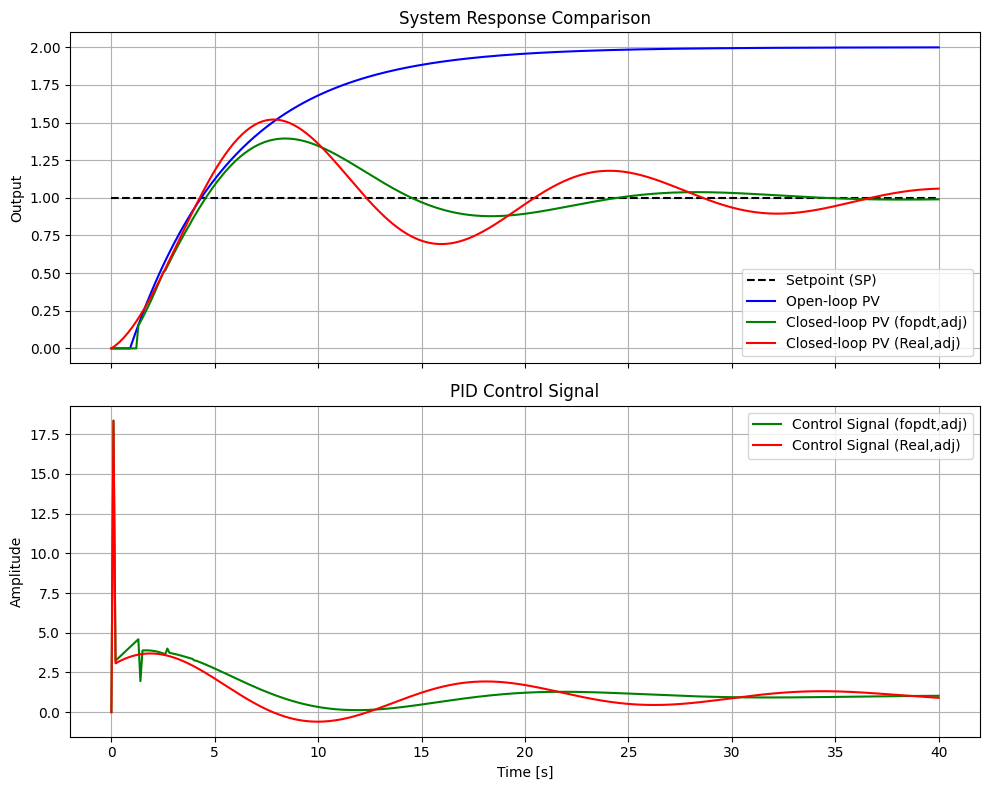

In [9]:
# adjustment
pid_params_adj = pid_params.copy()
pid_params_adj["Kp"] /= 4   # /= 3   # /= 2
pid_params_adj["Ki"] /= 4   # /= 3   # /= 2
pid_params_adj["Kd"] /= 4   # /= 3   # /= 2
print("pid_params_adj:")
#print(f"Kp: {pid_params_adj["Kp"]}| Ki: {pid_params_adj["Ki"]}| Kd: {pid_params_adj["Kd"]} ")
#print(f"Kc (Kp): {pid_params_adj["Kp"]}| Ti (Ki/Kp): {pid_params_adj["Ki"]/pid_params_adj["Kp"]}| Td (Kd/Kp): {pid_params_adj["Kd"]/pid_params_adj["Kp"]}| ")
print(f"Kc (Kp): {pid_params_adj["Kp"]}| Tn (Kp/Ki): {pid_params_adj["Kp"]/pid_params_adj["Ki"]}| Tv (Kd/Kp): {pid_params_adj["Kd"]/pid_params_adj["Kp"]}| ")



# Closed-loop simulation
t, sp, y_pid_adj_fopdt, u_pid_adj_fopdt = simulate_pid(
    pid_params_adj["Kp"], pid_params_adj["Ki"], pid_params_adj["Kd"],
    simulate_process_FOPDT_euler, {"K":fopdt_params["K"], "L":fopdt_params["L"], "T":fopdt_params["T"][0]}, dt, sim_time, D_on="e"
)
t, sp, y_pid_adj, u_pid_adj = simulate_pid(
    pid_params_adj["Kp"], pid_params_adj["Ki"], pid_params_adj["Kd"], 
    simulate_process_second_order, second_order_params, dt, sim_time, D_on="e"
)

# Plot comparison
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# System response
axs[0].plot(t, sp, "k--", label="Setpoint (SP)")
axs[0].plot(t, y_open_2, label="Open-loop PV", color="b")
axs[0].plot(t, y_pid_adj_fopdt, label="Closed-loop PV (fopdt,adj)", color="g")
axs[0].plot(t, y_pid_adj, label="Closed-loop PV (Real,adj)", color="r")
axs[0].set_title("System Response Comparison")
axs[0].set_ylabel("Output")
axs[0].legend()
axs[0].grid(True)

# Control signal
axs[1].plot(t, u_pid_adj_fopdt, label="Control Signal (fopdt,adj)", color="g")
axs[1].plot(t, u_pid_adj, label="Control Signal (Real,adj)", color="r")
axs[1].set_title("PID Control Signal")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Amplitude")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()